In [2]:
# CNN does what it’s good at → images

# MLP does what it’s good at → tabular data

# Model learns complementary information

In [36]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import os
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, Input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping



In [37]:
df = pd.read_csv(r'Data\Dataset.csv')
df

,id,log-sigma-1-0-mm-3D_glrlm_GrayLevelNonUniformity,log-sigma-1-0-mm-3D_ngtdm_Coarseness,minor_axis_length,area,log-sigma-1-0-mm-3D_gldm_DependenceNonUniformity,log-sigma-2-0-mm-3D_ngtdm_Coarseness,log-sigma-2-0-mm-3D_gldm_DependenceNonUniformity,log-sigma-2-0-mm-3D_glrlm_GrayLevelNonUniformity,wavelet-H_ngtdm_Coarseness,...,wavelet-H_glcm_JointEntropy,wavelet-H_glrlm_GrayLevelNonUniformityNormalized,log-sigma-2-0-mm-3D_glrlm_GrayLevelNonUniformityNormalized,log-sigma-1-0-mm-3D_glrlm_HighGrayLevelRunEmphasis,log-sigma-2-0-mm-3D_glcm_MCC,LBP_hist_bin_7,log-sigma-1-0-mm-3D_gldm_HighGrayLevelEmphasis,label,unexplained_infertility,previous_miscarriages
0,1,4809.535706,0.000247,198.625804,34583,12731.61441,0.000467,13018.03444,2687.906126,0.000138,...,3.863600,0.275603,0.205812,110.158185,0.839618,0.054680,111.058150,0,0,0
1,2,4460.623751,0.000284,193.191790,32053,11900.13194,0.000526,11521.54435,2826.917297,0.000162,...,4.119202,0.252179,0.187636,72.062320,0.853366,0.063489,72.682151,0,0,0
2,3,4925.207181,0.000240,199.327172,34346,13081.91446,0.000431,13580.04041,2784.541071,0.000135,...,3.434695,0.314459,0.231505,56.084546,0.845357,0.060094,56.346329,0,0,0
3,4,4664.352654,0.000257,195.713530,34131,12645.47833,0.000490,12945.91348,2610.770111,0.000141,...,3.599379,0.297244,0.199265,72.034173,0.868814,0.058949,72.831414,0,0,0
4,5,4420.923359,0.000271,196.147021,32842,12027.18696,0.000530,11766.90250,2474.527556,0.000152,...,3.922065,0.272541,0.179913,72.190030,0.855325,0.061050,72.673284,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,124,4568.094233,0.000288,219.654077,39686,14367.67661,0.000472,14273.76697,3055.538006,0.000139,...,3.333863,0.321830,0.175555,90.434190,0.869936,0.069445,90.857481,1,0,1
124,125,4664.626825,0.000275,218.066669,39662,14590.95351,0.000430,14823.92587,3175.472188,0.000136,...,3.076035,0.349690,0.193674,72.112061,0.883472,0.069538,72.611845,1,1,0
125,126,5203.038054,0.000240,229.486021,41192,14904.76695,0.000434,14441.28705,3412.583833,0.000128,...,4.018386,0.262754,0.175031,72.478047,0.846720,0.072174,72.935619,1,0,1
126,127,5362.058473,0.000235,227.372063,40050,14744.51181,0.000405,14445.17743,3592.559575,0.000131,...,4.098497,0.255446,0.195726,110.253146,0.847308,0.059026,110.723695,1,1,0


In [38]:
tabular_features = df.drop(['id', 'label'], axis=1)
labels = df['label']


In [39]:
Scaler = StandardScaler()
x_tabular = Scaler.fit_transform(tabular_features)
y = labels.values

In [40]:
height, width = 256, 256 
batch_size=16

In [41]:
image_folder = r"C:\Users\wesal\OneDrive\Desktop\Junior-fall\Machine Learning\Uterine-Abnormality\Ultrasound-Based-Classification-of-Uterine-Abnormalities\data\images"


image_list = []

for img_id in df['id']:
    img_name = f"{int(img_id):04d}" 
    img_name += '.jpg'
    
    img_path = os.path.join(image_folder, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        print(f"Warning: image not found -> {img_path}")
        continue
    
    img = img / 255.0
    
    img = img[..., np.newaxis]
    
    image_list.append(img)

X_img = np.array(image_list, dtype=np.float32)
print("Images loaded:", X_img.shape)

Images loaded: (128, 256, 256, 1)


In [42]:
y = labels.values if hasattr(labels, "values") else labels

X_img_train, X_img_val, X_tab_train, X_tab_val, y_train, y_val = train_test_split(
    X_img, x_tabular, y, test_size=0.2, random_state=42, stratify=y
)
print("Training samples:", X_img_train.shape[0])
print("Validation samples:", X_img_val.shape[0])


Training samples: 102
Validation samples: 26


In [44]:
image_input = Input(shape=(256, 256, 1))
x = RandomFlip("horizontal")(image_input)
x = RandomRotation(0.1)(x)   
x = RandomZoom(0.1)(x)  

x = Conv2D(32, (4,4), kernel_regularizer=l2(1e-4), padding='same')(x)
x = BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = MaxPooling2D((4,4))(x)

x = Conv2D(64, (3,3), kernel_regularizer=l2(1e-4),  padding='same')(x)
x = BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = MaxPooling2D((4,4))(x)
x = GlobalAveragePooling2D()(x)
# x = Flatten()(x)
x = Dense(64,     kernel_regularizer=l2(1e-4), activation='relu')(x)
x = Dropout(0.3)(x)
#GAP keeps the essence of each feature map, but dramatically reduces model size.



# MLP for tabular
tab_input = Input(shape=(x_tabular.shape[1],))
y = Dense(128, kernel_regularizer=l2(1e-4))(tab_input)
y = BatchNormalization()(y)
y = tf.keras.layers.ReLU()(y)
y = Dropout(0.3)(y)
y = Dense(64, activation='relu')(y)

#fusion
combined = concatenate([x, y])
z = Dense(64, activation='relu')(combined)
z = Dropout(0.3)(z)
output = Dense(1, activation='sigmoid')(z)

model = Model(inputs=[image_input, tab_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip         │ (None, 256, 256,  │          0 │ input_layer_12[0… │
│ (RandomFlip)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation     │ (None, 256, 256,  │          0 │ random_flip[0][0] │
│ (RandomRotation)    │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_zoom         │ (None, 256, 256,  │          0 │ random_rotation[… │
│ (RandomZoom)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 256, 256,  │        544 │ random_zoom[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_18 (ReLU)     │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 64, 64,    │          0 │ re_lu_18[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_12… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_13      │ (None, 400)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_19 (ReLU)     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 128)       │     51,328 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 16, 16,    │          0 │ re_lu_19[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_31[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ max_pooling2d_13… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_20 (ReLU)     │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 92,001 (359.38 KB)

 Trainable params: 91,553 (357.63 KB)

 Non-trainable params: 448 (1.75 KB)

In [45]:
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss', 
    save_best_only=True,  
    verbose=1
)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,       
    restore_best_weights=True,
    verbose=1
)


In [46]:
history = model.fit(
    [X_img_train, X_tab_train],
    y_train,
    validation_data=([X_img_val, X_tab_val], y_val),
    epochs=500,
    batch_size=16,
    callbacks=[checkpoint, early_stop]
)


Epoch 1/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - accuracy: 0.3997 - loss: 0.9047
Epoch 1: val_loss improved from None to 0.74669, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 823ms/step - accuracy: 0.4216 - loss: 0.9094 - val_accuracy: 0.5769 - val_loss: 0.7467
Epoch 2/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - accuracy: 0.4253 - loss: 0.7997
Epoch 2: val_loss improved from 0.74669 to 0.73239, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 653ms/step - accuracy: 0.4510 - loss: 0.8003 - val_accuracy: 0.5769 - val_loss: 0.7324
Epoch 3/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.4762 - loss: 0.7692
Epoch 3: val_loss improved from 0.73239 to 0.72205, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 710ms/step - accuracy: 0.4706 - loss: 0.7665 - val_accuracy: 0.6154 - val_loss: 0.7220
Epoch 4/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - accuracy: 0.5449 - loss: 0.7692
Epoch 4: val_loss improved from 0.72205 to 0.71360, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 692ms/step - accuracy: 0.5588 - loss: 0.7629 - val_accuracy: 0.6154 - val_loss: 0.7136
Epoch 5/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - accuracy: 0.5804 - loss: 0.7402
Epoch 5: val_loss improved from 0.71360 to 0.70832, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 673ms/step - accuracy: 0.5294 - loss: 0.7797 - val_accuracy: 0.5769 - val_loss: 0.7083
Epoch 6/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 618ms/step - accuracy: 0.5321 - loss: 0.7222
Epoch 6: val_loss improved from 0.70832 to 0.70385, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 673ms/step - accuracy: 0.5686 - loss: 0.6969 - val_accuracy: 0.5769 - val_loss: 0.7038
Epoch 7/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 616ms/step - accuracy: 0.5550 - loss: 0.6927
Epoch 7: val_loss improved from 0.70385 to 0.69717, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 729ms/step - accuracy: 0.5686 - loss: 0.6983 - val_accuracy: 0.5769 - val_loss: 0.6972
Epoch 8/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 664ms/step - accuracy: 0.5411 - loss: 0.7601
Epoch 8: val_loss improved from 0.69717 to 0.69335, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 771ms/step - accuracy: 0.5294 - loss: 0.7566 - val_accuracy: 0.5769 - val_loss: 0.6934
Epoch 9/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 663ms/step - accuracy: 0.6317 - loss: 0.6576
Epoch 9: val_loss improved from 0.69335 to 0.68941, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 737ms/step - accuracy: 0.6275 - loss: 0.6610 - val_accuracy: 0.5769 - val_loss: 0.6894
Epoch 10/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - accuracy: 0.5208 - loss: 0.7130
Epoch 10: val_loss improved from 0.68941 to 0.68712, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 725ms/step - accuracy: 0.5490 - loss: 0.6955 - val_accuracy: 0.5769 - val_loss: 0.6871
Epoch 11/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - accuracy: 0.6973 - loss: 0.6197
Epoch 11: val_loss improved from 0.68712 to 0.68486, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 673ms/step - accuracy: 0.7059 - loss: 0.6095 - val_accuracy: 0.5769 - val_loss: 0.6849
Epoch 12/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - accuracy: 0.6726 - loss: 0.6592
Epoch 12: val_loss improved from 0.68486 to 0.68347, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 735ms/step - accuracy: 0.6863 - loss: 0.6478 - val_accuracy: 0.6154 - val_loss: 0.6835
Epoch 13/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 798ms/step - accuracy: 0.6504 - loss: 0.6476
Epoch 13: val_loss improved from 0.68347 to 0.68214, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 871ms/step - accuracy: 0.6275 - loss: 0.6546 - val_accuracy: 0.6154 - val_loss: 0.6821
Epoch 14/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.7359 - loss: 0.5890
Epoch 14: val_loss improved from 0.68214 to 0.68065, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 688ms/step - accuracy: 0.6765 - loss: 0.6191 - val_accuracy: 0.6154 - val_loss: 0.6807
Epoch 15/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 734ms/step - accuracy: 0.5233 - loss: 0.7259
Epoch 15: val_loss improved from 0.68065 to 0.67711, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 792ms/step - accuracy: 0.5686 - loss: 0.6976 - val_accuracy: 0.6154 - val_loss: 0.6771
Epoch 16/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7188 - loss: 0.6129
Epoch 16: val_loss improved from 0.67711 to 0.67256, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.6961 - loss: 0.6305 - val_accuracy: 0.6154 - val_loss: 0.6726
Epoch 17/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6562 - loss: 0.6599
Epoch 17: val_loss improved from 0.67256 to 0.66795, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6569 - loss: 0.6659 - val_accuracy: 0.6538 - val_loss: 0.6679
Epoch 18/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6180 - loss: 0.6659
Epoch 18: val_loss improved from 0.66795 to 0.66501, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6471 - loss: 0.6472 - val_accuracy: 0.6538 - val_loss: 0.6650
Epoch 19/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5687 - loss: 0.6619
Epoch 19: val_loss improved from 0.66501 to 0.65973, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5882 - loss: 0.6646 - val_accuracy: 0.6538 - val_loss: 0.6597
Epoch 20/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6213 - loss: 0.6588
Epoch 20: val_loss improved from 0.65973 to 0.65291, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6863 - loss: 0.6332 - val_accuracy: 0.6538 - val_loss: 0.6529
Epoch 21/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6857 - loss: 0.6138
Epoch 21: val_loss improved from 0.65291 to 0.64617, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6863 - loss: 0.6127 - val_accuracy: 0.6538 - val_loss: 0.6462
Epoch 22/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7061 - loss: 0.5753
Epoch 22: val_loss improved from 0.64617 to 0.64088, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.6961 - loss: 0.5912 - val_accuracy: 0.6538 - val_loss: 0.6409
Epoch 23/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7013 - loss: 0.6436
Epoch 23: val_loss improved from 0.64088 to 0.63823, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7255 - loss: 0.6107 - val_accuracy: 0.6538 - val_loss: 0.6382
Epoch 24/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6793 - loss: 0.6164
Epoch 24: val_loss improved from 0.63823 to 0.63563, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7157 - loss: 0.6038 - val_accuracy: 0.6154 - val_loss: 0.6356
Epoch 25/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7289 - loss: 0.5788
Epoch 25: val_loss improved from 0.63563 to 0.63209, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7451 - loss: 0.5897 - val_accuracy: 0.6538 - val_loss: 0.6321
Epoch 26/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6621 - loss: 0.5935
Epoch 26: val_loss improved from 0.63209 to 0.62836, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6765 - loss: 0.5774 - val_accuracy: 0.6538 - val_loss: 0.6284
Epoch 27/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7144 - loss: 0.5715
Epoch 27: val_loss improved from 0.62836 to 0.62269, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.7059 - loss: 0.5950 - val_accuracy: 0.6923 - val_loss: 0.6227
Epoch 28/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8242 - loss: 0.5382
Epoch 28: val_loss improved from 0.62269 to 0.61875, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7941 - loss: 0.5565 - val_accuracy: 0.6923 - val_loss: 0.6187
Epoch 29/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7136 - loss: 0.5853
Epoch 29: val_loss did not improve from 0.61875
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.7157 - loss: 0.5835 - val_accuracy: 0.6923 - val_loss: 0.6193
Epoch 30/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7911 - loss: 0.5555
Epoch 30: val_loss did not improve from 0.61875
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7647 - loss: 0.5736 - val_accuracy: 0.6923 - val_loss: 0.6195
Epoch 31/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6302 - loss: 0.6457
Epoch 31: val_loss improved from 0.61875 to 0.61570, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6471 - loss: 0.6185 - val_accuracy: 0.6923 - val_loss: 0.6157
Epoch 32/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7919 - loss: 0.5444
Epoch 32: val_loss improved from 0.61570 to 0.61018, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7745 - loss: 0.5499 - val_accuracy: 0.7308 - val_loss: 0.6102
Epoch 33/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7911 - loss: 0.5032
Epoch 33: val_loss improved from 0.61018 to 0.60453, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7647 - loss: 0.5101 - val_accuracy: 0.7308 - val_loss: 0.6045
Epoch 34/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7065 - loss: 0.5510
Epoch 34: val_loss improved from 0.60453 to 0.59854, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7549 - loss: 0.5270 - val_accuracy: 0.6923 - val_loss: 0.5985
Epoch 35/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7764 - loss: 0.5106
Epoch 35: val_loss improved from 0.59854 to 0.59372, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7451 - loss: 0.5422 - val_accuracy: 0.6923 - val_loss: 0.5937
Epoch 36/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7363 - loss: 0.5243
Epoch 36: val_loss improved from 0.59372 to 0.58989, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7549 - loss: 0.5233 - val_accuracy: 0.6923 - val_loss: 0.5899
Epoch 37/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7212 - loss: 0.5503
Epoch 37: val_loss improved from 0.58989 to 0.58609, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7549 - loss: 0.5212 - val_accuracy: 0.7308 - val_loss: 0.5861
Epoch 38/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8047 - loss: 0.4804
Epoch 38: val_loss improved from 0.58609 to 0.58070, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8039 - loss: 0.4870 - val_accuracy: 0.7308 - val_loss: 0.5807
Epoch 39/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7609 - loss: 0.5000
Epoch 39: val_loss improved from 0.58070 to 0.57919, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7451 - loss: 0.5182 - val_accuracy: 0.7308 - val_loss: 0.5792
Epoch 40/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7882 - loss: 0.4995
Epoch 40: val_loss improved from 0.57919 to 0.57773, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7549 - loss: 0.5178 - val_accuracy: 0.7692 - val_loss: 0.5777
Epoch 41/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7791 - loss: 0.5139
Epoch 41: val_loss did not improve from 0.57773
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7745 - loss: 0.5329 - val_accuracy: 0.7692 - val_loss: 0.5792
Epoch 42/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8004 - loss: 0.4634
Epoch 42: val_loss did not improve from 0.57773
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7941 - loss: 0.4728 - val_accuracy: 0.7692 - val_loss: 0.5781
Epoch 43/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 960ms/step - accuracy: 0.7748 - loss: 0.4832
Epoch 43: val_loss improved from 0.57773 to 0.57396, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7941 - loss: 0.4681 - val_accuracy: 0.7692 - val_loss: 0.5740
Epoch 44/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 880ms/step - accuracy: 0.8718 - loss: 0.4342
Epoch 44: val_loss improved from 0.57396 to 0.57155, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 943ms/step - accuracy: 0.8431 - loss: 0.4562 - val_accuracy: 0.7692 - val_loss: 0.5715
Epoch 45/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.7947 - loss: 0.5010
Epoch 45: val_loss improved from 0.57155 to 0.56653, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 724ms/step - accuracy: 0.8137 - loss: 0.4963 - val_accuracy: 0.7692 - val_loss: 0.5665
Epoch 46/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.7670 - loss: 0.4989
Epoch 46: val_loss improved from 0.56653 to 0.56151, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 673ms/step - accuracy: 0.7745 - loss: 0.4896 - val_accuracy: 0.7692 - val_loss: 0.5615
Epoch 47/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 831ms/step - accuracy: 0.8635 - loss: 0.4232
Epoch 47: val_loss improved from 0.56151 to 0.55632, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 906ms/step - accuracy: 0.8333 - loss: 0.4387 - val_accuracy: 0.8077 - val_loss: 0.5563
Epoch 48/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.8069 - loss: 0.4275
Epoch 48: val_loss improved from 0.55632 to 0.55184, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 700ms/step - accuracy: 0.8235 - loss: 0.4232 - val_accuracy: 0.7692 - val_loss: 0.5518
Epoch 49/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 693ms/step - accuracy: 0.7858 - loss: 0.4734
Epoch 49: val_loss improved from 0.55184 to 0.54882, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 773ms/step - accuracy: 0.7941 - loss: 0.4703 - val_accuracy: 0.8077 - val_loss: 0.5488
Epoch 50/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - accuracy: 0.8848 - loss: 0.4070
Epoch 50: val_loss did not improve from 0.54882
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 718ms/step - accuracy: 0.8235 - loss: 0.4402 - val_accuracy: 0.8077 - val_loss: 0.5507
Epoch 51/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 620ms/step - accuracy: 0.9145 - loss: 0.3704
Epoch 51: val_loss improved from 0.54882 to 0.54850, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 689ms/step - accuracy: 0.8922 - loss: 0.3765 - val_accuracy: 0.7692 - val_loss: 0.5485
Epoch 52/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - accuracy: 0.8634 - loss: 0.3883
Epoch 52: val_loss improved from 0.54850 to 0.54327, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 752ms/step - accuracy: 0.8824 - loss: 0.3901 - val_accuracy: 0.7692 - val_loss: 0.5433
Epoch 53/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.8813 - loss: 0.4097
Epoch 53: val_loss improved from 0.54327 to 0.54289, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 701ms/step - accuracy: 0.8725 - loss: 0.4231 - val_accuracy: 0.7308 - val_loss: 0.5429
Epoch 54/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - accuracy: 0.8055 - loss: 0.4497
Epoch 54: val_loss improved from 0.54289 to 0.53345, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 697ms/step - accuracy: 0.8824 - loss: 0.3894 - val_accuracy: 0.7308 - val_loss: 0.5334
Epoch 55/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.8601 - loss: 0.3686
Epoch 55: val_loss improved from 0.53345 to 0.52419, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 668ms/step - accuracy: 0.8725 - loss: 0.3686 - val_accuracy: 0.7308 - val_loss: 0.5242
Epoch 56/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 758ms/step - accuracy: 0.7976 - loss: 0.4258
Epoch 56: val_loss improved from 0.52419 to 0.51547, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 826ms/step - accuracy: 0.8039 - loss: 0.4250 - val_accuracy: 0.7308 - val_loss: 0.5155
Epoch 57/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 692ms/step - accuracy: 0.8818 - loss: 0.4069
Epoch 57: val_loss improved from 0.51547 to 0.51455, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 749ms/step - accuracy: 0.8922 - loss: 0.4089 - val_accuracy: 0.7308 - val_loss: 0.5146
Epoch 58/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 632ms/step - accuracy: 0.8645 - loss: 0.3970
Epoch 58: val_loss improved from 0.51455 to 0.50528, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 688ms/step - accuracy: 0.8725 - loss: 0.4104 - val_accuracy: 0.7692 - val_loss: 0.5053
Epoch 59/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step - accuracy: 0.8456 - loss: 0.3838
Epoch 59: val_loss improved from 0.50528 to 0.50428, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 700ms/step - accuracy: 0.8431 - loss: 0.3777 - val_accuracy: 0.7692 - val_loss: 0.5043
Epoch 60/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - accuracy: 0.8732 - loss: 0.4065
Epoch 60: val_loss improved from 0.50428 to 0.49835, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 753ms/step - accuracy: 0.9020 - loss: 0.3757 - val_accuracy: 0.7692 - val_loss: 0.4984
Epoch 61/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 680ms/step - accuracy: 0.8805 - loss: 0.3446
Epoch 61: val_loss improved from 0.49835 to 0.49105, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 733ms/step - accuracy: 0.8824 - loss: 0.3313 - val_accuracy: 0.7692 - val_loss: 0.4911
Epoch 62/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - accuracy: 0.8545 - loss: 0.3503
Epoch 62: val_loss improved from 0.49105 to 0.47802, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 679ms/step - accuracy: 0.8824 - loss: 0.3384 - val_accuracy: 0.7692 - val_loss: 0.4780
Epoch 63/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 620ms/step - accuracy: 0.9450 - loss: 0.3527
Epoch 63: val_loss improved from 0.47802 to 0.46582, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 677ms/step - accuracy: 0.9118 - loss: 0.3567 - val_accuracy: 0.7692 - val_loss: 0.4658
Epoch 64/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 723ms/step - accuracy: 0.8831 - loss: 0.3440
Epoch 64: val_loss improved from 0.46582 to 0.46483, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 789ms/step - accuracy: 0.8725 - loss: 0.3656 - val_accuracy: 0.8077 - val_loss: 0.4648
Epoch 65/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 703ms/step - accuracy: 0.9186 - loss: 0.3898
Epoch 65: val_loss did not improve from 0.46483
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 741ms/step - accuracy: 0.8529 - loss: 0.4403 - val_accuracy: 0.7692 - val_loss: 0.4719
Epoch 66/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 672ms/step - accuracy: 0.8432 - loss: 0.3781
Epoch 66: val_loss did not improve from 0.46483
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 720ms/step - accuracy: 0.8627 - loss: 0.3606 - val_accuracy: 0.7692 - val_loss: 0.4762
Epoch 67/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 661ms/step - accuracy: 0.8825 - loss: 0.3587
Epoch 67: val_loss did not improve from 0.46483
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 697ms/step - accuracy: 0.8922 - loss: 0.3372 - val_accuracy: 0.7692 - val_loss: 0.4723
Epoch 68/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - accuracy: 0.8637 - loss: 0.3718
Epoch 68: val_loss improved from 0.46483 to 0.45425

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 656ms/step - accuracy: 0.9118 - loss: 0.3510 - val_accuracy: 0.7692 - val_loss: 0.4543
Epoch 69/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - accuracy: 0.9133 - loss: 0.3361
Epoch 69: val_loss improved from 0.45425 to 0.43943, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 689ms/step - accuracy: 0.9216 - loss: 0.3175 - val_accuracy: 0.8077 - val_loss: 0.4394
Epoch 70/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - accuracy: 0.8370 - loss: 0.3744
Epoch 70: val_loss improved from 0.43943 to 0.43292, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 651ms/step - accuracy: 0.8431 - loss: 0.3642 - val_accuracy: 0.8077 - val_loss: 0.4329
Epoch 71/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.9109 - loss: 0.2853
Epoch 71: val_loss improved from 0.43292 to 0.42505, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 667ms/step - accuracy: 0.8922 - loss: 0.3103 - val_accuracy: 0.8462 - val_loss: 0.4251
Epoch 72/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 594ms/step - accuracy: 0.9223 - loss: 0.3244
Epoch 72: val_loss did not improve from 0.42505
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 639ms/step - accuracy: 0.9510 - loss: 0.2964 - val_accuracy: 0.8846 - val_loss: 0.4348
Epoch 73/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 684ms/step - accuracy: 0.8872 - loss: 0.3288
Epoch 73: val_loss did not improve from 0.42505
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 731ms/step - accuracy: 0.8824 - loss: 0.3355 - val_accuracy: 0.8462 - val_loss: 0.4388
Epoch 74/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - accuracy: 0.9281 - loss: 0.2838
Epoch 74: val_loss did not improve from 0.42505
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 639ms/step - accuracy: 0.9314 - loss: 0.2872 - val_accuracy: 0.8077 - val_loss: 0.4383
Epoch 75/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.8904 - loss: 0.3711
Epoch 75: val_loss did not improve from 0.42505
7/7 

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 662ms/step - accuracy: 0.9020 - loss: 0.3324 - val_accuracy: 0.8077 - val_loss: 0.4233
Epoch 80/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - accuracy: 0.9352 - loss: 0.2536
Epoch 80: val_loss improved from 0.42329 to 0.40054, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 658ms/step - accuracy: 0.9216 - loss: 0.2861 - val_accuracy: 0.8462 - val_loss: 0.4005
Epoch 81/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.9194 - loss: 0.2443
Epoch 81: val_loss improved from 0.40054 to 0.38108, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 638ms/step - accuracy: 0.9412 - loss: 0.2439 - val_accuracy: 0.8462 - val_loss: 0.3811
Epoch 82/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - accuracy: 0.9453 - loss: 0.2781
Epoch 82: val_loss did not improve from 0.38108
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 631ms/step - accuracy: 0.9412 - loss: 0.2690 - val_accuracy: 0.8462 - val_loss: 0.3861
Epoch 83/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 723ms/step - accuracy: 0.9394 - loss: 0.2314
Epoch 83: val_loss did not improve from 0.38108
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 763ms/step - accuracy: 0.9216 - loss: 0.2472 - val_accuracy: 0.8462 - val_loss: 0.4043
Epoch 84/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 633ms/step - accuracy: 0.9517 - loss: 0.2454
Epoch 84: val_loss did not improve from 0.38108
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 686ms/step - accuracy: 0.9412 - loss: 0.2539 - val_accuracy: 0.8462 - val_loss: 0.4021
Epoch 85/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 756ms/step - accuracy: 0.9266 - loss: 0.2721
Epoch 85: val_loss did not improve from 0.38108
7/7

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 654ms/step - accuracy: 0.9706 - loss: 0.2456 - val_accuracy: 0.8846 - val_loss: 0.3432
Epoch 87/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.9796 - loss: 0.1948
Epoch 87: val_loss improved from 0.34323 to 0.32606, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 667ms/step - accuracy: 0.9706 - loss: 0.1977 - val_accuracy: 0.8846 - val_loss: 0.3261
Epoch 88/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 605ms/step - accuracy: 0.9050 - loss: 0.2438
Epoch 88: val_loss improved from 0.32606 to 0.32532, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 669ms/step - accuracy: 0.9020 - loss: 0.2467 - val_accuracy: 0.8846 - val_loss: 0.3253
Epoch 89/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - accuracy: 0.9484 - loss: 0.2531
Epoch 89: val_loss improved from 0.32532 to 0.31628, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 649ms/step - accuracy: 0.9118 - loss: 0.2741 - val_accuracy: 0.9231 - val_loss: 0.3163
Epoch 90/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 595ms/step - accuracy: 0.9733 - loss: 0.2102
Epoch 90: val_loss improved from 0.31628 to 0.31532, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 646ms/step - accuracy: 0.9706 - loss: 0.2043 - val_accuracy: 0.9231 - val_loss: 0.3153
Epoch 91/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - accuracy: 0.8960 - loss: 0.2920
Epoch 91: val_loss did not improve from 0.31532
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 655ms/step - accuracy: 0.9020 - loss: 0.2834 - val_accuracy: 0.8846 - val_loss: 0.3160
Epoch 92/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - accuracy: 0.9463 - loss: 0.2253
Epoch 92: val_loss improved from 0.31532 to 0.31525, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 637ms/step - accuracy: 0.9314 - loss: 0.2334 - val_accuracy: 0.8846 - val_loss: 0.3152
Epoch 93/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - accuracy: 0.9344 - loss: 0.2666
Epoch 93: val_loss did not improve from 0.31525
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 636ms/step - accuracy: 0.9314 - loss: 0.2525 - val_accuracy: 0.8462 - val_loss: 0.3266
Epoch 94/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 605ms/step - accuracy: 0.9740 - loss: 0.1865
Epoch 94: val_loss did not improve from 0.31525
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 639ms/step - accuracy: 0.9314 - loss: 0.2326 - val_accuracy: 0.8462 - val_loss: 0.3225
Epoch 95/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - accuracy: 0.9761 - loss: 0.2259
Epoch 95: val_loss did not improve from 0.31525
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 632ms/step - accuracy: 0.9608 - loss: 0.2301 - val_accuracy: 0.8077 - val_loss: 0.3174
Epoch 96/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 616ms/step - accuracy: 0.9357 - loss: 0.2667
Epoch 96: val_loss improved from 0.31525 to 0.30213,

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 669ms/step - accuracy: 0.9510 - loss: 0.2351 - val_accuracy: 0.8846 - val_loss: 0.3021
Epoch 97/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.9018 - loss: 0.2538
Epoch 97: val_loss improved from 0.30213 to 0.29168, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 640ms/step - accuracy: 0.9314 - loss: 0.2332 - val_accuracy: 0.9231 - val_loss: 0.2917
Epoch 98/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 634ms/step - accuracy: 0.9371 - loss: 0.2164
Epoch 98: val_loss improved from 0.29168 to 0.28457, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 713ms/step - accuracy: 0.9314 - loss: 0.2179 - val_accuracy: 0.9231 - val_loss: 0.2846
Epoch 99/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9427 - loss: 0.2285
Epoch 99: val_loss improved from 0.28457 to 0.27610, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 771ms/step - accuracy: 0.9510 - loss: 0.2087 - val_accuracy: 0.9615 - val_loss: 0.2761
Epoch 100/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 713ms/step - accuracy: 0.9531 - loss: 0.2110
Epoch 100: val_loss did not improve from 0.27610
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 758ms/step - accuracy: 0.9510 - loss: 0.2100 - val_accuracy: 0.8846 - val_loss: 0.2902
Epoch 101/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - accuracy: 0.9725 - loss: 0.1815
Epoch 101: val_loss did not improve from 0.27610
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 654ms/step - accuracy: 0.9412 - loss: 0.2227 - val_accuracy: 0.8846 - val_loss: 0.3003
Epoch 102/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 629ms/step - accuracy: 0.9826 - loss: 0.1875
Epoch 102: val_loss did not improve from 0.27610
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 667ms/step - accuracy: 0.9706 - loss: 0.1949 - val_accuracy: 0.8462 - val_loss: 0.3240
Epoch 103/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 709ms/step - accuracy: 0.8779 - loss: 0.2584
Epoch 103: val_loss did not improve from 0.

In [47]:
val_loss, val_acc = model.evaluate([X_img_val, X_tab_val], y_val)
print("Validation accuracy:", val_acc)
y_pred = model.predict([X_img_val, X_tab_val])
y_pred = (y_pred > 0.5).astype(int)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9615 - loss: 0.2761
Validation accuracy: 0.9615384340286255
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step


In [48]:
from tensorflow.keras.models import load_model

best_model = load_model('best_model.h5')


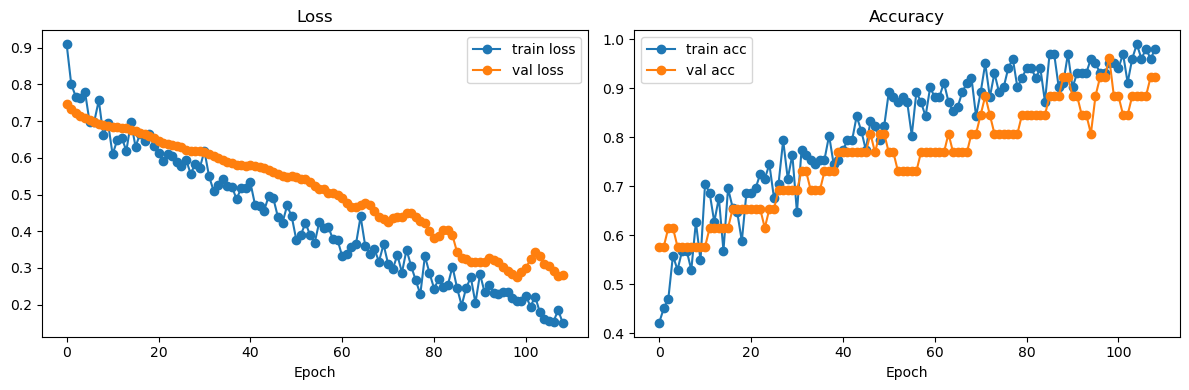

In [49]:
history_dict = history.history
loss = history_dict.get('loss')
val_loss = history_dict.get('val_loss')
acc = history_dict.get('accuracy', history_dict.get('acc'))
val_acc = history_dict.get('val_accuracy', history_dict.get('val_acc'))

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(loss, 'o-', label='train loss')
plt.plot(val_loss, 'o-', label='val loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
if acc is not None and val_acc is not None:
    plt.plot(acc, 'o-', label='train acc')
    plt.plot(val_acc, 'o-', label='val acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
else:
    plt.text(0.5, 0.5, 'No accuracy data in history', ha='center', va='center')

plt.tight_layout()
plt.show()